In [1]:
# import argparse
import numpy as np
import torch
from torch import nn
from torch.autograd import Function
from torch.autograd import Variable

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

# Define peakfuntion and test

In [2]:
def peakfunction(t):
    z1 = 3*(1-t[0])**2*torch.exp(-t[0]**2-(t[1]+1)**2)
    z2 = 10*(0.2*t[0]-torch.pow(t[0],3)-torch.pow(t[1],5))*torch.exp(-t[0]**2-t[1]**2)
    z3 = 1/3*torch.exp(-(t[0]+1)**2-t[1]**2)
    return z1-z2-z3

In [3]:
a = torch.tensor([0.23,-1.63], requires_grad= True)
peakfunction(a)

tensor(-6.5508, grad_fn=<SubBackward0>)

In [4]:
z = peakfunction(torch.tensor([0.23,-1.63]))
z

tensor(-6.5508)

# Minimize the function deirectly

In [5]:
# x = torch.tensor([0., 0.], requires_grad = True) #stuck to local optimal when start point is (0,0)

# optimizer = torch.optim.Adam([x], lr=1e-3)
# for step in range(20001):
#     if step:
#         optimizer.zero_grad()
#         f.backward()
#         optimizer.step()
#     f = peakfunction(x)
#     if step % 1000 == 0:
#         print ('step:{} , x = {} , value = {}'.format(step, x.tolist(), f))

In [6]:
# x = torch.tensor([0.2, -1.5], requires_grad = True)

# optimizer = torch.optim.Adam([x], lr=1e-3)
# for step in range(20001):
#     if step:
#         optimizer.zero_grad()
#         f.backward()
#         optimizer.step()
#     f = peakfunction(x)
#     if step % 1000 == 0:
#         print ('step:{} , x = {} , value = {}'.format(step, x.tolist(), f))

# Create datset subjected to Gaussian distribution

## Create 2D Gaussian distributed data

In [7]:
# np.random.seed(seed=2020)
torch.manual_seed(2021)
a1 = torch.rand(size=(50000, 2))
a = 6*a1-3
a.shape

torch.Size([50000, 2])

In [8]:
b = []
for i in range(50000):
    tem=peakfunction(a[i])
    b.append(tem)
b = torch.tensor(b)

In [9]:
b.shape

torch.Size([50000])

In [10]:
b[0]

tensor(-0.7654)

In [11]:
np.min(b.numpy())

-6.5501122

## Draw the figure

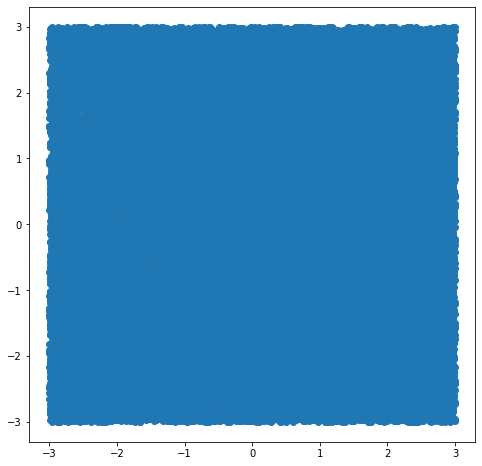

In [12]:
fig = plt.figure(figsize=(8,8))
plt.scatter(a[:,0], a[:,1])

<ipython-input-13-3582c56a4d5a>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


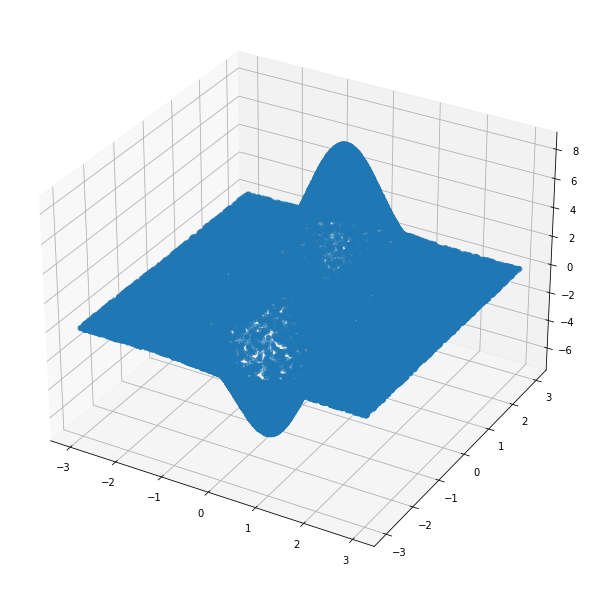

In [13]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(a[:,0], a[:,1], b)
plt.show()

## Create Dataset

In [14]:
import torch.utils.data as Data

In [15]:
BATCHSIZE=100

In [16]:
torch.random.manual_seed(2021)
index = np.random.permutation(len(b))
index

array([43464, 35920, 44903, ...,  2254,  6590, 41738])

In [17]:
X = a[index]
Y = b[index]

In [18]:
X[:4],Y[:4]

(tensor([[ 0.1245, -2.9904],
         [ 1.9902,  1.9632],
         [-1.8902, -0.7393],
         [-2.5377,  2.2217]]),
 tensor([-0.2647,  0.1479, -0.5022,  0.0042]))

In [19]:
peakfunction(X[:4][2])

tensor(-0.5022)

In [20]:
X_train = X[:40000]
Y_train = Y[:40000]

X_test = X[40000:]
Y_test = Y[40000:]

In [21]:
Train_ds = Data.TensorDataset(X_train,Y_train)

In [22]:
Test_ds = Data.TensorDataset(X_test,Y_test)

In [23]:
Train_DL = Data.DataLoader(Train_ds, batch_size=BATCHSIZE, shuffle=True)
Test_DL = Data.DataLoader(Test_ds, batch_size=BATCHSIZE, shuffle=False)

In [24]:
x, y = next(iter(Train_DL))

In [25]:
x.shape, y.shape

(torch.Size([100, 2]), torch.Size([100]))

In [26]:
x[:5], y[:5]

(tensor([[-0.1403,  2.5576],
         [-1.0090, -0.1291],
         [-0.8746,  1.6491],
         [-1.6512,  1.0118],
         [-1.9405, -2.0135]]),
 tensor([ 1.5483, -1.2121,  3.5719, -0.7859,  0.0519]))

In [27]:
#check the batch value
for i in range(5):
    print(peakfunction(x[:5][i]))

tensor(1.5483)
tensor(-1.2121)
tensor(3.5719)
tensor(-0.7859)
tensor(0.0519)


# Define the network

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 1)
        self.drop = nn.Dropout(0.5)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.relu(self.fc3(x))
        x = self.drop(x)
        x = torch.relu(self.fc4(x))
        x = self.drop(x)
        x = self.fc5(x)
        return x

In [29]:
model = Net()

In [30]:
model

Net(
  (fc1): Linear(in_features=2, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=1, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [31]:
def loss1(x,y):
    y_prediction = model(x)
    return torch.mean(torch.pow(y_prediction-y,2),dim=0)

In [32]:
loss_fn = torch.nn.MSELoss() #损失函数
# loss_fn1 = torch.nn.L1Loss() #损失函数

In [33]:
def fit(epoch, model, Train_DL, Test_DL):
    correct = 0
    running_loss = 0 #计算每个batch的loss
    
    model.train()
    
    for x, y in Train_DL:
        y_pred = model(x)
        y_pred = y_pred.squeeze(-1) #。。。。。。。?
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = model(x)
            running_loss +=loss.item()
        
    epoch_loss = running_loss/len(Train_DL.dataset)
    
    model.eval()
    
    test_correct = 0
    test_running_loss = 0 #计算每个batch的loss 
    with torch.no_grad():
        for x,y in Test_DL:
            y_pred = model(x)
            y_pred = y_pred.squeeze(-1)#。。。。。。。
            loss = loss_fn(y_pred, y)
            test_running_loss +=loss.item()
        
#     epoch_test_acc = test_correct/test_total
    epoch_test_loss = test_running_loss/len(Test_DL.dataset)
    
    
    if (epoch) % 50 == 0:
        print('epoch:', epoch, 'loss: ',round(epoch_loss,5), #不需要加item因为累计的值已经为标量了
              'test_loss: ',round(epoch_test_loss,5))
    
    return epoch_loss,epoch_test_loss

In [34]:
optim = torch.optim.Adam(model.parameters(),lr=0.0001)

In [35]:
epochs = 1250

In [81]:
train_loss = []
# train_acc = []

test_loss = []
# test_acc =[]
for epoch in range(epochs+1):
    epoch_loss, epoch_test_loss = fit(epoch,
                                      model,
                                      Train_DL,
                                      Test_DL)
    train_loss.append(epoch_loss)
#     train_acc.append(epoch_acc)
    
    test_loss.append(epoch_test_loss)
#     test_acc.append(epoch_test_acc)

epoch: 0 loss:  0.00085 test_loss:  0.00049
epoch: 50 loss:  0.00086 test_loss:  0.00051
epoch: 100 loss:  0.00086 test_loss:  0.00056
epoch: 150 loss:  0.00084 test_loss:  0.00049
epoch: 200 loss:  0.00084 test_loss:  0.00056
epoch: 250 loss:  0.00085 test_loss:  0.00053
epoch: 300 loss:  0.00082 test_loss:  0.00055
epoch: 350 loss:  0.00085 test_loss:  0.00057
epoch: 400 loss:  0.00082 test_loss:  0.0006
epoch: 450 loss:  0.00081 test_loss:  0.00056
epoch: 500 loss:  0.00082 test_loss:  0.00058
epoch: 550 loss:  0.0008 test_loss:  0.00057
epoch: 600 loss:  0.00081 test_loss:  0.00059
epoch: 650 loss:  0.00083 test_loss:  0.00062
epoch: 700 loss:  0.00082 test_loss:  0.00061
epoch: 750 loss:  0.0008 test_loss:  0.00063
epoch: 800 loss:  0.00082 test_loss:  0.00061
epoch: 850 loss:  0.00081 test_loss:  0.00061
epoch: 900 loss:  0.00079 test_loss:  0.00067
epoch: 950 loss:  0.0008 test_loss:  0.00064
epoch: 1000 loss:  0.00078 test_loss:  0.00064
epoch: 1050 loss:  0.00079 test_loss:  0

In [82]:
y_train_pred =model(X_train)
y_test_pred =model(X_test)

(-6.0, 6.0)

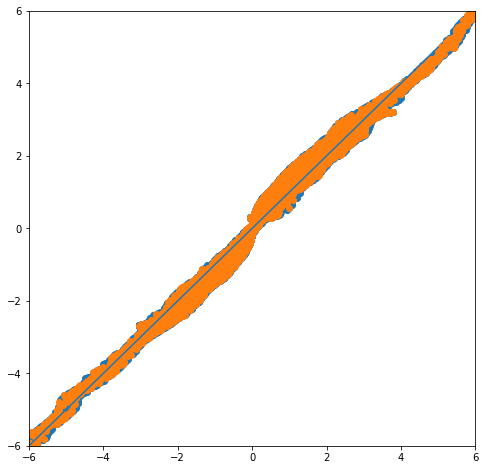

In [83]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(-6,6),np.arange(-6,6))
plt.scatter(Y_train.detach().numpy(),y_train_pred.detach().numpy())
plt.scatter(Y_test.detach().numpy(),y_test_pred.detach().numpy())
plt.xlim([-6,6])
plt.ylim([-6,6])

In [39]:
# 哼，就不让你运行下面代码！

# save the model

In [84]:
PATH = 'peakfunction_model_new.pth'
torch.save(model.state_dict(), PATH) #模型中的可训练参数

In [85]:
Designer_model = Net()

In [86]:
Designer_model.load_state_dict(torch.load(PATH)) #加载权重

<All keys matched successfully>

In [87]:
torch.manual_seed(2021)
inp = torch.normal(0, 1.5, size=(1000, 2))
inp[:5]

tensor([[-0.2178,  1.4620],
        [ 0.9034,  2.3663],
        [ 0.8550,  0.6409],
        [-0.0031, -2.4678],
        [ 0.7626,  1.0506]])

(-3.0, 3.0)

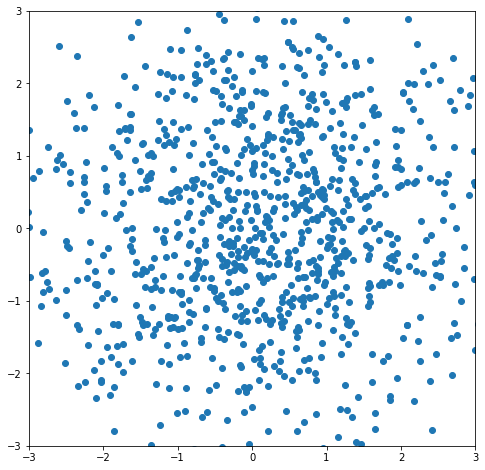

In [88]:
fig = plt.figure(figsize=(8,8))
plt.scatter(inp[:,0], inp[:,1])
plt.xlim([-3,3])
plt.ylim([-3,3])

In [89]:
inp.requires_grad =True

In [90]:
outp = []
for i in range(1000):
    tem=peakfunction(inp[i])
    outp.append(tem)
outp = torch.tensor(outp)

In [91]:
outp.shape

torch.Size([1000])

In [92]:
np.min(outp.numpy())

-6.5126324

In [93]:
Designer_model(inp)

tensor([[ 7.6762e+00],
        [ 8.7481e-01],
        [ 1.9768e+00],
        [-1.7816e+00],
        [ 3.1120e+00],
        [-6.1974e-01],
        [-1.5083e+00],
        [ 4.2890e-01],
        [ 5.3177e-02],
        [ 5.7201e-01],
        [ 2.3854e+00],
        [-7.0389e-01],
        [ 2.9077e+00],
        [-2.8830e-01],
        [ 7.7289e-02],
        [-2.9299e-02],
        [ 6.9795e+00],
        [ 1.0033e+00],
        [ 6.9013e-01],
        [ 1.5532e+00],
        [ 1.1085e-02],
        [-5.1594e-02],
        [ 3.8697e+00],
        [ 7.7762e-01],
        [-1.3851e+00],
        [ 3.4693e-01],
        [-1.7347e-01],
        [ 1.6521e+00],
        [ 1.0293e+00],
        [ 1.4451e-03],
        [ 1.6079e+00],
        [-1.1386e-01],
        [-4.3621e-03],
        [ 2.4315e+00],
        [ 8.9612e-01],
        [ 2.3316e+00],
        [ 1.8156e+00],
        [ 2.4238e+00],
        [ 1.6137e+00],
        [-3.9810e-01],
        [ 1.3090e+00],
        [ 3.4678e-01],
        [ 2.4218e+00],
        [ 5

In [94]:
BE =Designer_model(inp)
BE

tensor([[ 6.7673e+00],
        [ 1.1649e+00],
        [ 1.9542e+00],
        [-1.9822e+00],
        [ 3.3085e+00],
        [-2.7758e-01],
        [-1.2879e+00],
        [ 2.9430e-01],
        [ 2.0716e-01],
        [ 5.4243e-01],
        [ 1.9511e+00],
        [-8.6763e-01],
        [ 3.3639e+00],
        [-1.1915e-01],
        [ 1.0298e-01],
        [-1.2241e-01],
        [ 7.3044e+00],
        [ 1.3681e+00],
        [ 2.0641e-01],
        [ 1.3986e+00],
        [ 2.4202e-02],
        [-2.6673e-03],
        [ 3.5048e+00],
        [ 9.2540e-01],
        [-1.7993e+00],
        [ 1.6299e-01],
        [-3.9190e-02],
        [ 1.4211e+00],
        [ 1.1608e+00],
        [-2.9934e-02],
        [ 1.7796e+00],
        [-2.4993e-01],
        [-3.9801e-02],
        [ 2.4188e+00],
        [ 2.8396e-01],
        [ 2.4557e+00],
        [ 1.4974e+00],
        [ 1.6067e+00],
        [ 1.6747e+00],
        [ 4.9427e-01],
        [ 1.7917e+00],
        [ 2.9094e-01],
        [ 1.9071e+00],
        [ 3

In [95]:
np.min(BE.detach().numpy()), np.max(BE.detach().numpy())

(-6.2057014, 8.765751)

In [96]:
for param in Designer_model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.4804e-03, -3.1583e-01],
        [-5.4812e-01,  5.4149e-01],
        [-2.2370e-02, -4.7115e-01],
        [ 2.3734e-01, -2.9209e-01],
        [ 1.5668e-01, -1.7068e-01],
        [ 7.5684e-02, -8.1373e-02],
        [ 4.6568e-03, -1.5177e-01],
        [ 1.5431e-01,  1.3952e-01],
        [ 1.9115e-01, -6.2031e-02],
        [ 4.0385e-02,  7.0648e-03],
        [-4.4261e-02, -4.1776e-01],
        [ 2.3486e-01, -4.9378e-01],
        [-4.8437e-01, -3.2272e-01],
        [ 1.1286e-01,  8.6047e-02],
        [ 4.7933e-01,  8.7665e-03],
        [ 2.2115e-01,  2.1088e-01],
        [-3.2239e-01, -2.9958e-01],
        [-2.8188e-01, -2.7092e-01],
        [ 2.3802e-01,  2.1483e-01],
        [ 1.7914e-01, -5.1952e-01],
        [-4.8611e-03,  4.2921e-01],
        [ 3.4707e-01, -6.1986e-01],
        [-2.5127e-02, -2.9433e-01],
        [ 2.6087e-01,  2.2604e-01],
        [ 7.3348e-02, -7.6338e-02],
        [ 2.1962e-01, -4.6918e-01],
        [ 6.2805e-02, -4.6980e-01],
      

In [97]:
for p in Designer_model.parameters():p.requires_grad=False

In [98]:
crit = lambda x: x.sum()

In [99]:
optim1 = torch.optim.Adam([inp],lr=0.001)

for iter in range(5000):
    loss= crit(Designer_model(inp))
    print(iter, loss.item())
    optim1.zero_grad()
    loss.backward()
    optim1.step()

0 774.002197265625
1 760.471435546875
2 772.646484375
3 758.9577026367188
4 748.4960327148438
5 775.815185546875
6 748.3932495117188
7 744.100341796875
8 736.75
9 717.708984375
10 725.5917358398438
11 695.549072265625
12 718.8184204101562
13 730.0274658203125
14 709.3821411132812
15 713.5036010742188
16 734.57958984375
17 710.3594970703125
18 691.6822509765625
19 693.4019165039062
20 686.5604858398438
21 688.9906616210938
22 707.44970703125
23 687.6948852539062
24 685.66259765625
25 684.9673461914062
26 654.9439086914062
27 673.931884765625
28 656.4854736328125
29 666.6641235351562
30 645.237060546875
31 651.2152099609375
32 647.6932983398438
33 656.025390625
34 633.6373901367188
35 642.236328125
36 633.1570434570312
37 609.8634033203125
38 610.3475341796875
39 608.689453125
40 615.7744140625
41 606.5331420898438
42 616.3848266601562
43 613.1588134765625
44 618.172119140625
45 605.7239990234375
46 599.5677490234375
47 590.2894287109375
48 591.5057983398438
49 581.80322265625
50 578.383

395 -565.2767333984375
396 -558.302490234375
397 -586.6765747070312
398 -561.2214965820312
399 -571.0762939453125
400 -582.4033203125
401 -581.3431396484375
402 -583.5658569335938
403 -587.5517578125
404 -584.3011474609375
405 -586.3074951171875
406 -598.6453857421875
407 -606.7127075195312
408 -602.1636962890625
409 -599.1920776367188
410 -611.5119018554688
411 -594.7471313476562
412 -618.6876831054688
413 -622.2327880859375
414 -615.307861328125
415 -620.8436279296875
416 -621.1563720703125
417 -624.7750244140625
418 -624.0079345703125
419 -638.8642578125
420 -635.842529296875
421 -626.5847778320312
422 -647.2394409179688
423 -642.0668334960938
424 -637.8931884765625
425 -656.3780517578125
426 -649.5700073242188
427 -642.3447265625
428 -663.8348999023438
429 -641.6676635742188
430 -672.9057006835938
431 -656.5146484375
432 -660.5112915039062
433 -677.4307861328125
434 -675.5410766601562
435 -685.3536987304688
436 -668.1458740234375
437 -664.4879760742188
438 -686.0526123046875
439 -6

775 -1463.176025390625
776 -1469.22314453125
777 -1472.996337890625
778 -1494.315185546875
779 -1505.0399169921875
780 -1480.9759521484375
781 -1475.8819580078125
782 -1499.074951171875
783 -1497.120849609375
784 -1504.76611328125
785 -1500.52587890625
786 -1499.0531005859375
787 -1502.5009765625
788 -1500.210693359375
789 -1515.3077392578125
790 -1512.2403564453125
791 -1513.545166015625
792 -1506.026611328125
793 -1511.3966064453125
794 -1521.2872314453125
795 -1515.5201416015625
796 -1532.803955078125
797 -1523.4608154296875
798 -1534.185791015625
799 -1535.109619140625
800 -1538.312744140625
801 -1523.89794921875
802 -1533.161376953125
803 -1532.5869140625
804 -1522.7633056640625
805 -1521.8228759765625
806 -1551.4765625
807 -1529.4189453125
808 -1535.5911865234375
809 -1543.281005859375
810 -1535.4404296875
811 -1532.952392578125
812 -1545.8260498046875
813 -1549.9251708984375
814 -1548.5654296875
815 -1542.8641357421875
816 -1545.829833984375
817 -1568.6708984375
818 -1558.822021

1129 -1888.790771484375
1130 -1877.1278076171875
1131 -1887.056884765625
1132 -1875.64892578125
1133 -1885.751953125
1134 -1896.5924072265625
1135 -1894.1591796875
1136 -1851.514892578125
1137 -1865.819091796875
1138 -1894.8719482421875
1139 -1897.24560546875
1140 -1889.3240966796875
1141 -1886.70068359375
1142 -1875.60205078125
1143 -1877.0782470703125
1144 -1868.0101318359375
1145 -1905.536376953125
1146 -1906.865234375
1147 -1883.15283203125
1148 -1887.746337890625
1149 -1898.3955078125
1150 -1887.1087646484375
1151 -1891.869873046875
1152 -1903.997314453125
1153 -1885.825927734375
1154 -1890.884765625
1155 -1879.4525146484375
1156 -1866.8753662109375
1157 -1898.0806884765625
1158 -1894.646240234375
1159 -1911.4613037109375
1160 -1887.7379150390625
1161 -1905.0450439453125
1162 -1877.6192626953125
1163 -1905.0963134765625
1164 -1916.638427734375
1165 -1903.1632080078125
1166 -1892.427490234375
1167 -1902.8123779296875
1168 -1923.4530029296875
1169 -1907.658203125
1170 -1909.74902343

1479 -2039.232177734375
1480 -2021.3919677734375
1481 -2045.47412109375
1482 -2060.5576171875
1483 -2044.381591796875
1484 -2039.5732421875
1485 -2048.844482421875
1486 -2053.209716796875
1487 -2024.8785400390625
1488 -2039.3021240234375
1489 -2046.7926025390625
1490 -2042.0052490234375
1491 -2050.128173828125
1492 -2047.3839111328125
1493 -2033.5750732421875
1494 -2060.14501953125
1495 -2046.216552734375
1496 -2042.01904296875
1497 -2032.5562744140625
1498 -2036.7236328125
1499 -2041.0091552734375
1500 -2047.4844970703125
1501 -2042.6676025390625
1502 -2039.2384033203125
1503 -2043.677490234375
1504 -2065.4033203125
1505 -2032.6553955078125
1506 -2054.03271484375
1507 -2034.0106201171875
1508 -2050.20654296875
1509 -2034.622802734375
1510 -2046.8798828125
1511 -2062.939453125
1512 -2058.226318359375
1513 -2065.9814453125
1514 -2053.18798828125
1515 -2023.63525390625
1516 -2042.2298583984375
1517 -2026.370849609375
1518 -2046.4925537109375
1519 -2049.420166015625
1520 -2037.40502929687

1835 -2104.70361328125
1836 -2115.20361328125
1837 -2125.791748046875
1838 -2098.586181640625
1839 -2118.08203125
1840 -2109.67041015625
1841 -2089.126708984375
1842 -2101.08740234375
1843 -2125.4931640625
1844 -2104.662109375
1845 -2090.2685546875
1846 -2110.60107421875
1847 -2109.986572265625
1848 -2112.870849609375
1849 -2103.92431640625
1850 -2104.016357421875
1851 -2116.062744140625
1852 -2125.220458984375
1853 -2119.107177734375
1854 -2099.435302734375
1855 -2107.93212890625
1856 -2123.65234375
1857 -2128.9345703125
1858 -2118.46435546875
1859 -2107.9375
1860 -2094.852783203125
1861 -2119.318359375
1862 -2138.134765625
1863 -2094.448486328125
1864 -2097.110595703125
1865 -2097.080078125
1866 -2108.962646484375
1867 -2094.135498046875
1868 -2116.1083984375
1869 -2135.197021484375
1870 -2102.859619140625
1871 -2107.93701171875
1872 -2111.173828125
1873 -2139.31201171875
1874 -2102.0908203125
1875 -2119.25439453125
1876 -2107.5087890625
1877 -2131.024658203125
1878 -2143.271484375
1

2219 -2141.01123046875
2220 -2164.645263671875
2221 -2143.251220703125
2222 -2137.924072265625
2223 -2157.93603515625
2224 -2134.7001953125
2225 -2155.55419921875
2226 -2131.460693359375
2227 -2141.218505859375
2228 -2141.169921875
2229 -2165.943603515625
2230 -2174.758056640625
2231 -2139.752685546875
2232 -2169.76025390625
2233 -2178.766357421875
2234 -2154.68896484375
2235 -2172.615234375
2236 -2172.67041015625
2237 -2152.655517578125
2238 -2123.066162109375
2239 -2144.64111328125
2240 -2162.51416015625
2241 -2153.14306640625
2242 -2143.120849609375
2243 -2152.759765625
2244 -2155.036376953125
2245 -2151.60986328125
2246 -2129.22900390625
2247 -2167.564697265625
2248 -2149.3134765625
2249 -2153.55810546875
2250 -2167.66357421875
2251 -2141.49267578125
2252 -2164.48095703125
2253 -2159.431396484375
2254 -2141.65576171875
2255 -2140.026611328125
2256 -2155.37646484375
2257 -2144.4755859375
2258 -2158.986083984375
2259 -2144.81982421875
2260 -2159.56689453125
2261 -2143.164794921875
22

2585 -2175.982177734375
2586 -2171.309814453125
2587 -2163.087890625
2588 -2177.923095703125
2589 -2188.65087890625
2590 -2179.075439453125
2591 -2199.336669921875
2592 -2184.0849609375
2593 -2166.96923828125
2594 -2170.166015625
2595 -2208.20947265625
2596 -2195.31591796875
2597 -2197.84423828125
2598 -2179.498291015625
2599 -2175.315673828125
2600 -2193.160400390625
2601 -2177.18701171875
2602 -2191.2177734375
2603 -2193.753173828125
2604 -2182.39453125
2605 -2158.15869140625
2606 -2167.965087890625
2607 -2188.16162109375
2608 -2190.33056640625
2609 -2177.502685546875
2610 -2169.5556640625
2611 -2169.992919921875
2612 -2169.45458984375
2613 -2181.486572265625
2614 -2183.36962890625
2615 -2199.64599609375
2616 -2187.28564453125
2617 -2174.5146484375
2618 -2169.80517578125
2619 -2161.325927734375
2620 -2170.19140625
2621 -2184.62255859375
2622 -2161.498291015625
2623 -2178.383056640625
2624 -2186.6669921875
2625 -2174.07666015625
2626 -2192.7666015625
2627 -2190.68359375
2628 -2181.887

2944 -2188.67822265625
2945 -2192.95068359375
2946 -2215.611328125
2947 -2218.59912109375
2948 -2207.993896484375
2949 -2191.153076171875
2950 -2189.636962890625
2951 -2200.674072265625
2952 -2212.269775390625
2953 -2201.0546875
2954 -2185.711181640625
2955 -2199.387939453125
2956 -2183.73876953125
2957 -2214.05712890625
2958 -2200.026611328125
2959 -2202.34423828125
2960 -2216.39404296875
2961 -2215.712158203125
2962 -2210.218017578125
2963 -2214.604248046875
2964 -2192.6015625
2965 -2213.771484375
2966 -2198.6259765625
2967 -2216.95556640625
2968 -2205.11962890625
2969 -2194.406494140625
2970 -2218.22509765625
2971 -2167.701904296875
2972 -2208.1826171875
2973 -2227.9443359375
2974 -2205.953369140625
2975 -2203.728759765625
2976 -2182.178955078125
2977 -2206.138427734375
2978 -2205.78173828125
2979 -2194.326416015625
2980 -2217.56689453125
2981 -2230.525146484375
2982 -2220.0234375
2983 -2208.41015625
2984 -2193.915771484375
2985 -2202.59423828125
2986 -2229.23681640625
2987 -2188.20

3314 -2236.367431640625
3315 -2248.334228515625
3316 -2221.580322265625
3317 -2243.09619140625
3318 -2238.561767578125
3319 -2250.3193359375
3320 -2226.875
3321 -2227.73046875
3322 -2252.546142578125
3323 -2234.556640625
3324 -2254.096435546875
3325 -2253.547607421875
3326 -2231.300537109375
3327 -2230.2529296875
3328 -2247.674560546875
3329 -2230.98876953125
3330 -2233.544677734375
3331 -2231.438232421875
3332 -2241.986328125
3333 -2229.584716796875
3334 -2240.72021484375
3335 -2242.9697265625
3336 -2242.8671875
3337 -2222.55517578125
3338 -2238.327392578125
3339 -2217.356201171875
3340 -2243.308837890625
3341 -2230.50390625
3342 -2230.87890625
3343 -2216.546875
3344 -2250.34033203125
3345 -2263.14111328125
3346 -2240.248779296875
3347 -2249.53515625
3348 -2240.079345703125
3349 -2222.39794921875
3350 -2234.504638671875
3351 -2235.71923828125
3352 -2235.051513671875
3353 -2227.20654296875
3354 -2232.00634765625
3355 -2225.08056640625
3356 -2271.350341796875
3357 -2221.282470703125
335

3685 -2268.97705078125
3686 -2255.59326171875
3687 -2270.23876953125
3688 -2285.854736328125
3689 -2228.4794921875
3690 -2287.534912109375
3691 -2244.287109375
3692 -2251.87744140625
3693 -2282.212646484375
3694 -2288.57421875
3695 -2252.03955078125
3696 -2268.73388671875
3697 -2268.94091796875
3698 -2262.975830078125
3699 -2249.38037109375
3700 -2232.749267578125
3701 -2244.71875
3702 -2247.003173828125
3703 -2249.732421875
3704 -2246.5068359375
3705 -2269.1708984375
3706 -2272.965087890625
3707 -2263.514892578125
3708 -2261.123779296875
3709 -2260.99609375
3710 -2262.15380859375
3711 -2281.09033203125
3712 -2255.153076171875
3713 -2244.471435546875
3714 -2255.8505859375
3715 -2263.514404296875
3716 -2289.474853515625
3717 -2263.320556640625
3718 -2237.097412109375
3719 -2241.258056640625
3720 -2258.969482421875
3721 -2251.24951171875
3722 -2277.7197265625
3723 -2262.212890625
3724 -2275.075439453125
3725 -2277.041015625
3726 -2262.3837890625
3727 -2251.919921875
3728 -2241.0798339843

4065 -2266.85400390625
4066 -2269.034912109375
4067 -2284.338623046875
4068 -2270.53857421875
4069 -2272.813720703125
4070 -2297.439208984375
4071 -2310.315185546875
4072 -2263.496337890625
4073 -2255.07861328125
4074 -2280.142822265625
4075 -2294.236572265625
4076 -2279.1572265625
4077 -2249.173095703125
4078 -2269.88037109375
4079 -2275.197998046875
4080 -2297.298828125
4081 -2271.19580078125
4082 -2294.16845703125
4083 -2278.4638671875
4084 -2256.755859375
4085 -2295.395751953125
4086 -2279.856201171875
4087 -2260.876220703125
4088 -2292.1494140625
4089 -2292.94921875
4090 -2282.92578125
4091 -2281.220703125
4092 -2273.037353515625
4093 -2317.677490234375
4094 -2276.879150390625
4095 -2294.545654296875
4096 -2270.914306640625
4097 -2273.53271484375
4098 -2309.769775390625
4099 -2276.662353515625
4100 -2283.3701171875
4101 -2267.888671875
4102 -2281.636962890625
4103 -2284.16796875
4104 -2275.418212890625
4105 -2287.60986328125
4106 -2262.418212890625
4107 -2277.339599609375
4108 -22

4442 -2296.71923828125
4443 -2283.2080078125
4444 -2273.054443359375
4445 -2300.3623046875
4446 -2300.336181640625
4447 -2276.6376953125
4448 -2299.453125
4449 -2287.990478515625
4450 -2309.78466796875
4451 -2288.60498046875
4452 -2289.696533203125
4453 -2278.517578125
4454 -2296.25048828125
4455 -2291.131591796875
4456 -2276.112548828125
4457 -2306.73828125
4458 -2296.03466796875
4459 -2289.49951171875
4460 -2312.207275390625
4461 -2296.066650390625
4462 -2294.33544921875
4463 -2313.484375
4464 -2298.5048828125
4465 -2294.029052734375
4466 -2292.915283203125
4467 -2294.857421875
4468 -2296.09619140625
4469 -2287.58154296875
4470 -2287.26611328125
4471 -2291.183349609375
4472 -2317.021728515625
4473 -2278.868896484375
4474 -2304.592041015625
4475 -2265.92431640625
4476 -2313.246337890625
4477 -2304.4423828125
4478 -2304.4287109375
4479 -2275.67578125
4480 -2299.09033203125
4481 -2282.673828125
4482 -2296.29736328125
4483 -2301.302734375
4484 -2301.909912109375
4485 -2290.145263671875
4

4815 -2296.5859375
4816 -2295.514892578125
4817 -2296.072265625
4818 -2296.7900390625
4819 -2290.872802734375
4820 -2300.103759765625
4821 -2314.18310546875
4822 -2297.298583984375
4823 -2292.162353515625
4824 -2312.861083984375
4825 -2297.6904296875
4826 -2298.621337890625
4827 -2302.85986328125
4828 -2315.675537109375
4829 -2330.511962890625
4830 -2308.66650390625
4831 -2294.37060546875
4832 -2323.636962890625
4833 -2308.496337890625
4834 -2292.62646484375
4835 -2304.302001953125
4836 -2286.987060546875
4837 -2301.334228515625
4838 -2297.891357421875
4839 -2293.3095703125
4840 -2269.316650390625
4841 -2298.840087890625
4842 -2294.80224609375
4843 -2315.43603515625
4844 -2296.5537109375
4845 -2304.45068359375
4846 -2279.589111328125
4847 -2307.348388671875
4848 -2312.049072265625
4849 -2289.42626953125
4850 -2318.378173828125
4851 -2294.8251953125
4852 -2318.372802734375
4853 -2283.77978515625
4854 -2297.615234375
4855 -2301.55419921875
4856 -2304.642822265625
4857 -2318.679931640625


In [100]:
for param in Designer_model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.4804e-03, -3.1583e-01],
        [-5.4812e-01,  5.4149e-01],
        [-2.2370e-02, -4.7115e-01],
        [ 2.3734e-01, -2.9209e-01],
        [ 1.5668e-01, -1.7068e-01],
        [ 7.5684e-02, -8.1373e-02],
        [ 4.6568e-03, -1.5177e-01],
        [ 1.5431e-01,  1.3952e-01],
        [ 1.9115e-01, -6.2031e-02],
        [ 4.0385e-02,  7.0648e-03],
        [-4.4261e-02, -4.1776e-01],
        [ 2.3486e-01, -4.9378e-01],
        [-4.8437e-01, -3.2272e-01],
        [ 1.1286e-01,  8.6047e-02],
        [ 4.7933e-01,  8.7665e-03],
        [ 2.2115e-01,  2.1088e-01],
        [-3.2239e-01, -2.9958e-01],
        [-2.8188e-01, -2.7092e-01],
        [ 2.3802e-01,  2.1483e-01],
        [ 1.7914e-01, -5.1952e-01],
        [-4.8611e-03,  4.2921e-01],
        [ 3.4707e-01, -6.1986e-01],
        [-2.5127e-02, -2.9433e-01],
        [ 2.6087e-01,  2.2604e-01],
        [ 7.3348e-02, -7.6338e-02],
        [ 2.1962e-01, -4.6918e-01],
        [ 6.2805e-02, -4.6980e-01],
      

In [101]:
inp[:5]

tensor([[-1.3009,  0.3237],
        [ 2.1647,  3.3613],
        [ 0.3087,  0.2859],
        [ 0.1024, -1.6633],
        [ 0.2983,  0.3131]], grad_fn=<SliceBackward>)

(-3.0, 3.0)

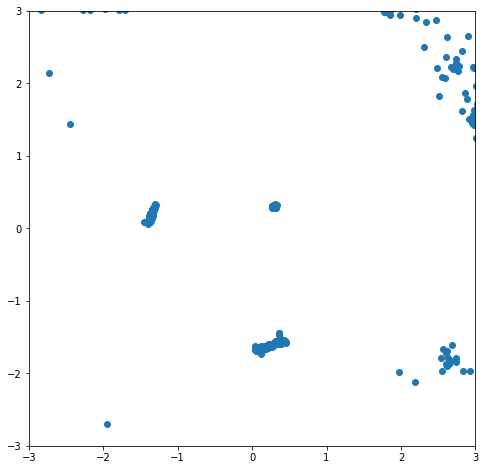

In [106]:
fig = plt.figure(figsize=(8,8))
plt.scatter(inp[:,0].detach().numpy(),inp[:,1].detach().numpy())
plt.xlim([-3,3])
plt.ylim([-3,3])

In [103]:
AF =Designer_model(inp)
AF

tensor([[-2.5196e+00],
        [-1.3850e-01],
        [ 3.9291e-01],
        [-5.2085e+00],
        [ 3.3617e-01],
        [-1.8452e+00],
        [-2.7315e+00],
        [-3.4443e-02],
        [-2.8046e+00],
        [ 8.0623e-02],
        [-5.8982e+00],
        [-2.9037e+00],
        [ 3.4398e-01],
        [-2.9065e+00],
        [ 4.5603e-02],
        [-3.5090e-02],
        [ 6.7588e-02],
        [ 4.6139e-02],
        [ 3.5559e-01],
        [ 5.6729e-02],
        [-2.4414e+00],
        [-3.0252e+00],
        [-6.0884e+00],
        [ 8.4927e-02],
        [-2.7143e+00],
        [ 2.2190e-02],
        [-5.7891e+00],
        [ 3.2553e-01],
        [ 1.5362e-01],
        [-1.0776e-01],
        [ 9.0530e-02],
        [-2.8924e+00],
        [ 1.5475e-02],
        [ 1.5747e-01],
        [-5.1624e+00],
        [ 1.2885e-02],
        [ 5.5577e-02],
        [ 1.8969e-03],
        [ 2.0690e-01],
        [-5.2746e+00],
        [-2.1878e+00],
        [-2.8038e+00],
        [-2.0995e-02],
        [ 1

In [104]:
np.min(AF.detach().numpy()), np.max(AF.detach().numpy())

(-8.067892, 0.92039603)